<a href="https://colab.research.google.com/github/MathewBiddle/sandbox/blob/main/notebooks/MBON_OBIS_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import subprocess
import sys

COLAB = "google.colab" in sys.modules


def _install(package):
    if COLAB:
        ans = input(f"Install { package }? [y/n]:")
        if ans.lower() in ["y", "yes"]:
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "--quiet", package]
            )
            print(f"{ package } installed!")


def _colab_install_missing_deps(deps):
    import importlib

    for dep in deps:
        if importlib.util.find_spec(dep) is None:
            if dep == "iris":
                dep = "scitools-iris"
            _install(dep)


deps = ["geoplot", "pyobis"]
_colab_install_missing_deps(deps)

# Using pyobis to query for known datasets

Created: 2024-03-13

Materials here were heavily leveraged from [this example](https://ioos.github.io/ioos_code_lab/content/code_gallery/data_access_notebooks/2022-11-23_pyobis_example.html).

Author: [Mathew Biddle](mailto:mathew.biddle@noaa.gov)

This notebook uses the [pyobis](https://github.com/iobis/pyobis) Python package to query the [OBIS API](https://api.obis.org/). It then takes those results to query the [GBIF API](https://techdocs.gbif.org/en/openapi/) for datasets associated with projects funded under the United States Marine Biodiversity Observation Network. The notebook walks through the process for querying the two api's for a specific institution, then using the resultant datasets to gather use metrics.

In [2]:
import pyobis

pyobis.__version__

'1.4.0'

First off, let's look through the available institutions at OBIS and find the US MBON one.

_Hint: We know the name of the institution is **United States Marine Biodiversity Observation Network**._

In [3]:
import pandas as pd

pd.set_option("max_colwidth", 400)

url = "https://api.obis.org/v3/institute"

institutes = pd.read_json(url)

df_inst = pd.DataFrame.from_records(institutes["results"])

df_inst.dropna(inplace=True)

df_inst["id"] = df_inst["id"].astype(int)

institution = df_inst.loc[
    df_inst["name"].str.contains(
        "United States Marine Biodiversity Observation", na=False
    )
]

institution

,id,name,country,records
58,23070,United States Marine Biodiversity Observation Network,United States of America,1615899


Well that looks like the institution we're after!

Using the `id` we can check it out on the OBIS website: https://obis.org/institute/23070

Yes, that does look like what we want. Now let's use that `id` to query OBIS for all associated datasets.

In [4]:
institution_id = institution["id"].tolist()[0]

institution_id

23070

## Collect metadata about all of the datasets

Here we use the `institution_id` collected from OBIS to query the API for metadata on the datasets associated with that `id`.

First, we build the API call, then we bring it into a Pandas DataFrame and create additional fields for use later.

In [5]:
import pyobis

query = pyobis.dataset.search(instituteid=institution_id)

df = pd.DataFrame(query.execute())

df_meta = pd.DataFrame.from_records(df["results"])

# create a column for the human readable short name of the datasets
df_meta["short_name"] = df_meta["url"].str.split("=", expand=True)[1]

# create another column to group datasets by, which removes the year from the short names
df_meta["short_name_group"] = df_meta["short_name"].replace("\d", "", regex=True)

#df_meta.head(5)

What are the pieces of information we have gathered from OBIS?

In [6]:
df_meta.columns

Index(['id', 'url', 'archive', 'published', 'created', 'updated', 'core',
       'extensions', 'statistics', 'extent', 'title', 'citation',
       'citation_id', 'abstract', 'intellectualrights', 'feed', 'institutes',
       'contacts', 'nodes', 'keywords', 'downloads', 'records', 'short_name',
       'short_name_group'],
      dtype='object')

## Collect statistics from OBIS

Collect number of downloads per dataset per year from OBIS and display on chart.

In [7]:
import numpy as np

df_downloads = pd.DataFrame.from_records(df_meta['downloads'])

#df_downloads.rename(columns={'index':'year'}, inplace=True)

df_downloads.fillna(value=np.nan)

,0,1,2,3,4,5,6
0,"{'year': 2024, 'downloads': 1646, 'records': 166130946}","{'year': 2023, 'downloads': 3648, 'records': 588494102}","{'year': 2022, 'downloads': 4191, 'records': 426899064}","{'year': 2021, 'downloads': 13776, 'records': 497036713}","{'year': 2020, 'downloads': 747, 'records': 26199396}",NaN,NaN
1,"{'year': 2024, 'downloads': 6020, 'records': 69733551}","{'year': 2023, 'downloads': 7679, 'records': 242648438}","{'year': 2022, 'downloads': 7478, 'records': 175113790}","{'year': 2021, 'downloads': 17549, 'records': 204507663}","{'year': 2020, 'downloads': 3443, 'records': 68153160}","{'year': 2019, 'downloads': 293, 'records': 8867930}","{'year': 2018, 'downloads': 1, 'records': 97617}"
2,"{'year': 2024, 'downloads': 6187, 'records': 61654888}","{'year': 2023, 'downloads': 7461, 'records': 215815493}","{'year': 2022, 'downloads': 7273, 'records': 158822384}","{'year': 2021, 'downloads': 17801, 'records': 178906115}","{'year': 2020, 'downloads': 3353, 'records': 59225761}","{'year': 2019, 'downloads': 299, 'records': 7648000}","{'year': 2018, 'downloads': 1, 'records': 87042}"
3,"{'year': 2024, 'downloads': 5981, 'records': 54574797}","{'year': 2023, 'downloads': 7513, 'records': 190581549}","{'year': 2022, 'downloads': 7350, 'records': 139710500}","{'year': 2021, 'downloads': 17831, 'records': 160861289}","{'year': 2020, 'downloads': 3556, 'records': 53543342}","{'year': 2019, 'downloads': 322, 'records': 7049786}","{'year': 2018, 'downloads': 1, 'records': 76543}"
4,"{'year': 2024, 'downloads': 5900, 'records': 54332886}","{'year': 2023, 'downloads': 7385, 'records': 189896655}","{'year': 2022, 'downloads': 7230, 'records': 138680258}","{'year': 2021, 'downloads': 17532, 'records': 160135207}","{'year': 2020, 'downloads': 3446, 'records': 53299681}","{'year': 2019, 'downloads': 341, 'records': 6924827}","{'year': 2018, 'downloads': 1, 'records': 76253}"
5,"{'year': 2024, 'downloads': 5762, 'records': 51799238}","{'year': 2023, 'downloads': 7113, 'records': 180599495}","{'year': 2022, 'downloads': 6965, 'records': 132387456}","{'year': 2021, 'downloads': 16595, 'records': 152199694}","{'year': 2020, 'downloads': 3213, 'records': 50632042}","{'year': 2019, 'downloads': 269, 'records': 6605189}","{'year': 2018, 'downloads': 1, 'records': 72606}"
6,"{'year': 2024, 'downloads': 6034, 'records': 47402258}","{'year': 2023, 'downloads': 7151, 'records': 165968503}","{'year': 2022, 'downloads': 6946, 'records': 122527551}","{'year': 2021, 'downloads': 16787, 'records': 137001971}","{'year': 2020, 'downloads': 3326, 'records': 46782489}","{'year': 2019, 'downloads': 264, 'records': 5813131}","{'year': 2018, 'downloads': 1, 'records': 66979}"
7,"{'year': 2024, 'downloads': 798, 'records': 43711161}","{'year': 2023, 'downloads': 3805, 'records': 159361913}","{'year': 2022, 'downloads': 3804, 'records': 111586878}","{'year': 2021, 'downloads': 1261, 'records': 34625165}",NaN,NaN,NaN
8,"{'year': 2024, 'downloads': 5879, 'records': 45501758}","{'year': 2023, 'downloads': 7316, 'records': 159290696}","{'year': 2022, 'downloads': 7040, 'records': 114702446}","{'year': 2021, 'downloads': 17152, 'records': 131795156}","{'year': 2020, 'downloads': 3474, 'records': 45420293}","{'year': 2019, 'downloads': 316, 'records': 5764191}","{'year': 2018, 'downloads': 1, 'records': 64253}"
9,"{'year': 2024, 'downloads': 5765, 'records': 43895179}","{'year': 2023, 'downloads': 7094, 'records': 153142966}","{'year': 2022, 'downloads': 6928, 'records': 110487360}","{'year': 2021, 'downloads': 17115, 'records': 129196233}","{'year': 2020, 'downloads': 3417, 'records': 43288935}","{'year': 2019, 'downloads': 327, 'records': 5997818}","{'year': 2018, 'downloads': 1, 'records': 61547}"


<Axes: title={'center': 'Dataset downloads per year from OBIS'}, ylabel='# of downloads'>

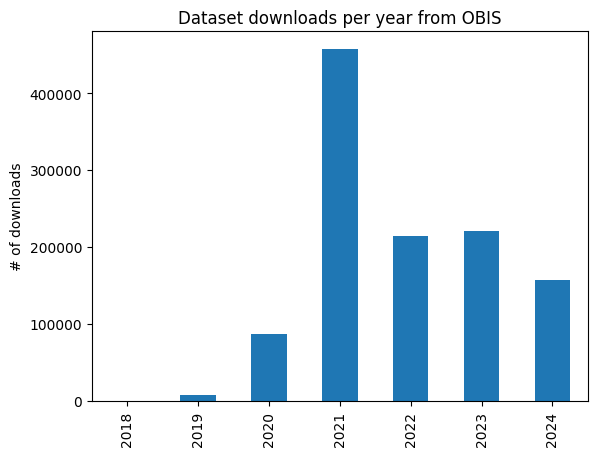

In [8]:
cols = [2024, 2023, 2022, 2021, 2020, 2019, 2018]
summary = df_downloads.applymap(lambda x: int(x["downloads"]) if x is not None else None).sum()
summary.index = cols
summary[::-1].plot(kind="bar",legend=False,ylabel='# of downloads', title='Dataset downloads per year from OBIS')

In [9]:
df_summary = pd.DataFrame(summary)

df_summary[0].sum()

1144278.0

# Search GBIF for statistics on the datasets we identified in OBIS

pygbif - https://pygbif.readthedocs.io/en/latest/index.html

GBIF API - https://techdocs.gbif.org/en/openapi/

In [10]:
base_url = 'https://api.gbif.org'

# Search GBIF for dataset titles that match the OBIS records

In [11]:
import urllib.parse

df_gbif = pd.DataFrame()

for title in df_meta['title']:
  string = title
  query = '{}/v1/dataset/search?q={}'.format(base_url,urllib.parse.quote(string))
  df = pd.read_json(query,orient='index').T

  key = df['results'].values[0][0]['key']

  #build a DataFrame with the info we need more accessible
  df_gbif = pd.concat([df_gbif, pd.DataFrame({
                  'key': df['results'].values[0][0]['key'],
                  'title': [df['results'].values[0][0]['title']],
                  'doi': [df['results'].values[0][0]['doi']]
                  } )], ignore_index=True)

df_gbif.head(2)

,key,title,doi
0,4ef2bed0-d40f-49c9-bb64-c46a301a5a72,"Abundance of Rocky Reef Fishes, Invertebrates and Algae, Reef Check California (RCCA), 2006 - 2017",10.25494/p6js3m
1,1ea1cb01-e168-4236-be23-8c86ec51fc3f,Florida Keys Reef Visual Census 2009,10.15468/tnn5ra


## Let's compute the total number of citations, from GBIF, for all the MBON datasets.

Now that we have the `dataset key` for GBIF for each of our OBIS datasets, we can start to look at our GBIF download statistics.

There are various API endpoints we can use:

| endpoint | description |
|----------|-------------|
| `'https://api.gbif.org/v1/occurrence/download/statistics?datasetKey={}&limit=100'.format(key)` | Filters for downloads matching the provided criteria, then provide counts by year, month and dataset of the total number of downloads, and the total number of records included in those downloads. |
| `'https://api.gbif.org/v1/occurrence/download/statistics/downloadedRecordsByDataset?datasetKey={}'.format(key)` | Summarizes downloaded record totals by month, filtered by a publishing organization's country, territory or island and/or a single dataset |
| `'https://api.gbif.org/v1/occurrence/download/statistics/downloadsByDataset?datasetKey={}'.format(key)` | Summarizes downloads by month, filtered by a publishing organization's country, territory or island and/or a single dataset |
| `'https://api.gbif.org/v1/literature/export?format=CSV&gbifDatasetKey={}'.format(key)` | summary of citations in an easily digestible form |

We will start with the last one as it's easy to work with.

Now, let's calculate the total number of citations for all of our MBON datasets.

In [12]:
for key in df_gbif['key']:

  df2 = pd.read_csv('https://api.gbif.org/v1/literature/export?format=CSV&gbifDatasetKey={}'.format(key)) # summary of citations
  df_gbif.loc[df_gbif['key']==key,'number_of_citations'] = df2.shape[0]

df_gbif['number_of_citations'].sum()


2131.0

In [13]:
df_gbif

,key,title,doi,number_of_citations
0,4ef2bed0-d40f-49c9-bb64-c46a301a5a72,"Abundance of Rocky Reef Fishes, Invertebrates and Algae, Reef Check California (RCCA), 2006 - 2017",10.25494/p6js3m,41.0
1,1ea1cb01-e168-4236-be23-8c86ec51fc3f,Florida Keys Reef Visual Census 2009,10.15468/tnn5ra,58.0
2,3063fd20-83ba-4716-9a5e-07fcea584f06,Dry Tortugas Reef Visual Census 2012,10.15468/adis7b,69.0
3,7c1373e6-36e2-486f-9e09-ef36cd12c6ed,Florida Keys Reef Visual Census 2011,10.15468/06aqle,67.0
4,9a71aa12-7636-4381-9986-d8f03240b277,Florida Keys Reef Visual Census 2012,10.15468/vnvtmr,62.0
5,e6712257-e922-4bc3-8b5e-e567a0458ad2,Florida Keys Reef Visual Census 2008,10.15468/7zofww,64.0
6,2501caa2-803b-4f6b-9e36-f9f5c72c0666,Dry Tortugas Reef Visual Census 2008,10.15468/oomxex,57.0
7,e0b59ee7-19ae-4eb0-9217-33317fb50d47,"18S Monterey Bay Time Series: an eDNA data set from Monterey Bay, California, including years 2006, 2013 - 2016",10.15468/84ntea,40.0
8,f31212ae-87f5-45e3-8c03-87a0cc5cb86f,Dry Tortugas Reef Visual Census 2010,10.15468/7dnpl0,65.0
9,1840aafc-6446-450e-9d7d-483790b20f6a,Florida Keys Reef Visual Census 2010,10.15468/6chrsz,66.0


## What other citation information can we gather from the API?

We can look at the types of literature citing these data.

Below is an example looking at the distribution of `topics` for one dataset:

In [14]:
key = '29651377-23c8-4f45-b439-693a1a23cee1'

df_gbif.loc[df_gbif['key']==key]

,key,title,doi,number_of_citations
38,29651377-23c8-4f45-b439-693a1a23cee1,Wilkinson Basin Time Series Station (WBTS): Mesozooplankton 2004-2017,10.15468/sqpu7z,11.0


<Axes: title={'center': 'Topics citing dataset Wilkinson Basin Time Series Station (WBTS): Mesozooplankton 2004-2017\ndoi:10.15468/sqpu7z'}>

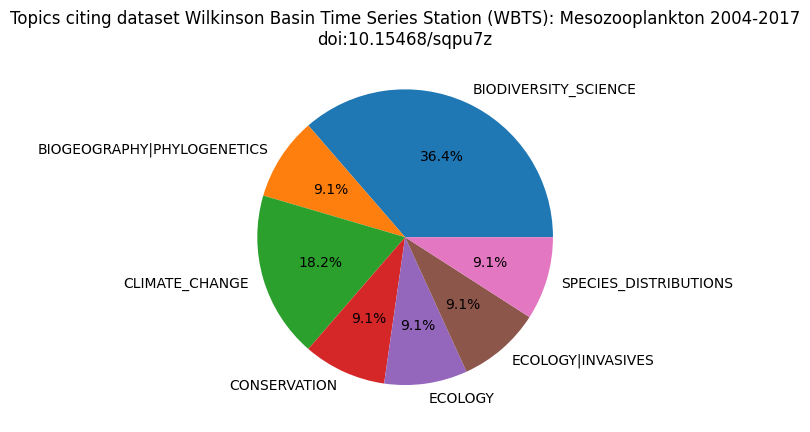

In [15]:
df2 = pd.read_csv('https://api.gbif.org/v1/literature/export?format=CSV&gbifDatasetKey={}'.format(key))

title = df_gbif.loc[df_gbif['key']==key,'title'].item()
doi = df_gbif.loc[df_gbif['key']==key, 'doi'].item()

df2.groupby(by='topics').count()['title'].plot(
    kind='pie',
    autopct='%2.1f%%',
    title='Topics citing dataset {}\ndoi:{}'.format(title, doi),
    ylabel='')

But, there are a lot of other things we can look at. Below is a list of the columns returned by the service:

In [16]:
df2.columns

Index(['title', 'authors', 'source', 'discovered', 'published', 'open_access',
       'peer_review', 'citation_type', 'countries_of_coverage',
       'countries_of_researcher', 'keywords', 'literature_type', 'websites',
       'identifiers', 'id', 'abstract', 'topics', 'added',
       'gbif_download_key'],
      dtype='object')

In [17]:
df2['source']

0                             International Journal of Extreme Manufacturing
1                                                      Ecology and Evolution
2                                      Review of Palaeobotany and Palynology
3                                            Global Ecology and Conservation
4                                                                   Authorea
5                                                            Research Square
6     Philosophical Transactions of the Royal Society B: Biological Sciences
7                                                    Biological Conservation
8                                                Frontiers in Marine Science
9                                                                     Zenodo
10                                                     Nature Communications
Name: source, dtype: object